In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'
# load Terra API for get data table from Terra
import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns

import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
obs_path = f'{RESULT_TABLE}/annotation/Epithelial.csv'
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Lineage=='Tumor']),:]
print(f"Detect N={adata.shape[0]:,} tumor cells with high quality GEX profiles;")
print(f"max(% of mitocondrial reads): {adata.obs['pct_counts_mito'].max():.0f}")
sample_meta =  pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')

Detect N=65,206 tumor cells with high quality GEX profiles;
max(% of mitocondrial reads): 5


# Detect the robust recurrent program robustRPH

- Run the workflow https://app.terra.bio/#workspaces/vanallen-firecloud-nih/HR_BrCa_16-466/workflows/jf_scpipe_rna/GEX_CohortSet_DetectRHP
    - Here, we directly use the tumor h5ad as input
- Get the basis and coef pickle files.

In [3]:
import pickle
with open(f'{RESULT_TABLE}/MPs/Tumor/nmf_basis.pickle', "rb") as input_file:
    programs_basis = pickle.load(input_file)

with open(f'{RESULT_TABLE}/MPs/Tumor/nmf_coef.pickle', "rb") as input_file:
    programs_coef = pickle.load(input_file)
    
n_programs = programs_basis[list(programs_basis.keys())[2]].shape[1] * len(programs_basis)
f"Generated {n_programs:,} programs"

'Generated 1,326 programs'

In [4]:
n_top=50
# robustRPH = sp.ext.getRobustRHP(programs=programs_basis,
#                          n_top=n_top,
#                          intra_min = 35, inter_min = 10,intra_max = 10
#                         )
# with open(f'RESULT_TABLE}/MPs/Tumor/robustRPH.pickle', 'wb') as handle:
#     pickle.dump(robustRPH, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{RESULT_TABLE}/MPs/Tumor/robustRPH.pickle', "rb") as input_file:
    robustRPH = pickle.load(input_file)
f"Out of {n_programs:,} detected programs, {robustRPH.shape[1]} programs are robust."

'Out of 1,326 detected programs, 195 programs are robust.'

## Get a list of genes in the analysis

In [5]:
bg_genes = pd.Index([])
for k,v in programs_basis.items():
    bg_genes = v.index.union(bg_genes)

## Customized clustering on the RPH

### Look at how the n of samples in various timepoints and conditions


In [6]:
sample_stats = pd.crosstab(index=[sample_meta['Treatment_Arm'],sample_meta['Timepoint']],
            columns=sample_meta['BestResponse'])

sample_stats['total'] =sample_stats.sum(axis=1)
sample_stats

BestResponse               favorable response\n(RCB 0-I)  \
Treatment_Arm Timepoint                                    
Chemo->Combo  Baseline                                 1   
              Pre-surgery                              0   
              Surgery                                  1   
              W3D1                                     2   
              W7D1                                     3   
ICI->Combo    Baseline                                 2   
              Pre-surgery                              1   
              Surgery                                  0   
              W3D1                                     0   
              W7D1                                     1   

BestResponse               unfavorable response\n(RCB II-III)  total  
Treatment_Arm Timepoint                                               
Chemo->Combo  Baseline                                      3      4  
              Pre-surgery                                   2      2  
              Surgery                                       2      3  
              W3D1                                          3      5  
              W7D1                                          1      4  
ICI->Combo    Baseline                                      6      8  
              Pre-surgery                                   1      2  
              Surgery                                       4      4  
              W3D1                                          4      4  
              W7D1                                          3      4

### Perform the clustering

as shown above, in timepoints Baseline, W3D1, W7D1, and AfterSurg, we have at least `2` samples per timepoints. Thus, we aimed to find metaprograms that at least shared among three samples and set the `Min_group_size` parameter to be `2`.

In [7]:
import palettable
Cluster_Map,MP_Genesets,Programs_Order,MP_colors = sp.ext.clusterRobustRPH(
    robustRPH=robustRPH,
    programs_basis=programs_basis,
    Min_group_size=2,
    palette=palettable.tableau.Tableau_20.hex_colors + palettable.tableau.TrafficLight_9.hex_colors
)

[Processing]Cluster MP1 has 32 RPH programs.
[Processing]Cluster MP2 has 24 RPH programs.
[Processing]Cluster MP3 has 12 RPH programs.
[Processing]Cluster MP4 has 7 RPH programs.
[Processing]Cluster MP5 has 5 RPH programs.
[Processing]Cluster MP6 has 6 RPH programs.
[Processing]Cluster MP7 has 3 RPH programs.
[Processing]Cluster MP8 has 5 RPH programs.
[Processing]Cluster MP9 has 4 RPH programs.
[Processing]Cluster MP10 has 4 RPH programs.
[Processing]Cluster MP11 has 5 RPH programs.
[Done] Generated 11 MP clusters which covered 55% robust RPH programs.


### Look at MPs related to low data quality 

In [8]:
display(pd.concat([
    MP_Genesets.apply(lambda c:c.str.startswith('MT-').sum(),axis=0).rename('Mitochondrial'),
    MP_Genesets.apply(lambda c:c.str.contains('^RP[LS]').sum(),axis=0).rename('Ribosomal')
],axis=1).sort_values(['Mitochondrial','Ribosomal'],ascending=False))

low_quality_mps = ['MP1']

,Mitochondrial,Ribosomal
MP1,10,33
MP10,2,0
MP2,0,0
MP3,0,0
MP4,0,0
MP5,0,0
MP6,0,0
MP7,0,0
MP8,0,0
MP9,0,0


### Merge sample metadata into the clustering result

In [9]:
anno = Cluster_Map.rename('MetaProgram').to_frame()
anno['Sample'] = anno.index.map(lambda x: x.split('.')[0])
anno = anno.reset_index().merge(sample_meta,left_on='Sample',right_on='CCG_ID',how='left').set_index('index')

### explore the patient specific programs

In [10]:
pt_specific = anno.groupby(['MetaProgram'])['Patient'].nunique().sort_values()
pt_specific = pt_specific[pt_specific ==1].index.tolist()

In [11]:
anno['MetaProgram'].value_counts()[pt_specific]

Series([], Name: MetaProgram, dtype: int64)

In [12]:
anno.loc[anno['MetaProgram'].isin(pt_specific),:]

,MetaProgram,Sample,CCG_ID,BluePrint,AC_Treatment,Tech,WES_Profile,BulkRNA_Profile,PAM50,BestResponse,Timepoint,stage,Patient,Treatment_Arm
index,,,,,,,,,,,,,,


###  Calculate the complexity correaltion

In [13]:
nmf_corr_complexity = []
for k,v in programs_coef.items():
    tmp = v.corrwith(adata.obs.loc[v.index,'n_genes_by_counts'])
    nmf_corr_complexity.append(tmp)
del tmp
nmf_corr_complexity=pd.concat(nmf_corr_complexity,axis=0)
dt = pd.concat([nmf_corr_complexity.abs()>.4,Cluster_Map],axis=1,join='inner').groupby(1)[0].mean()
high_complexity = dt[dt>.5].index.tolist()
high_complexity

['MP10']

In [14]:
dt[dt>.5]

1
MP10    0.75
Name: 0, dtype: float64

### Remove patient specific, high complexity, and unknown program

In [15]:
anno = anno.loc[~anno['MetaProgram'].isin(pt_specific+['MP_Unknown']+low_quality_mps+high_complexity),:]
New_Programs_Order = [ x for x in Programs_Order if x in anno.index]
New_MP_Genesets = MP_Genesets[anno['MetaProgram'].unique().tolist()]
f"Generated {anno['MetaProgram'].nunique()} MP clusters which covered {(anno.shape[0]/robustRPH.shape[1]):.0%} robust RPH programs."

'Generated 9 MP clusters which covered 36% robust RPH programs.'

## Visualize the program similarity 

### Visualize the similarity

In [16]:
def jaccard_index(c1,c2):
    c1 = set(c1)
    c2 = set(c2)
    overlap =  c1.intersection(c2)
    union = c1.union(c2)
    value = len(overlap)/len(union)
    return value

## Jaccard index    
sm = robustRPH.apply(
        lambda c1:
            robustRPH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.22361111111111 mm
Incresing ncol


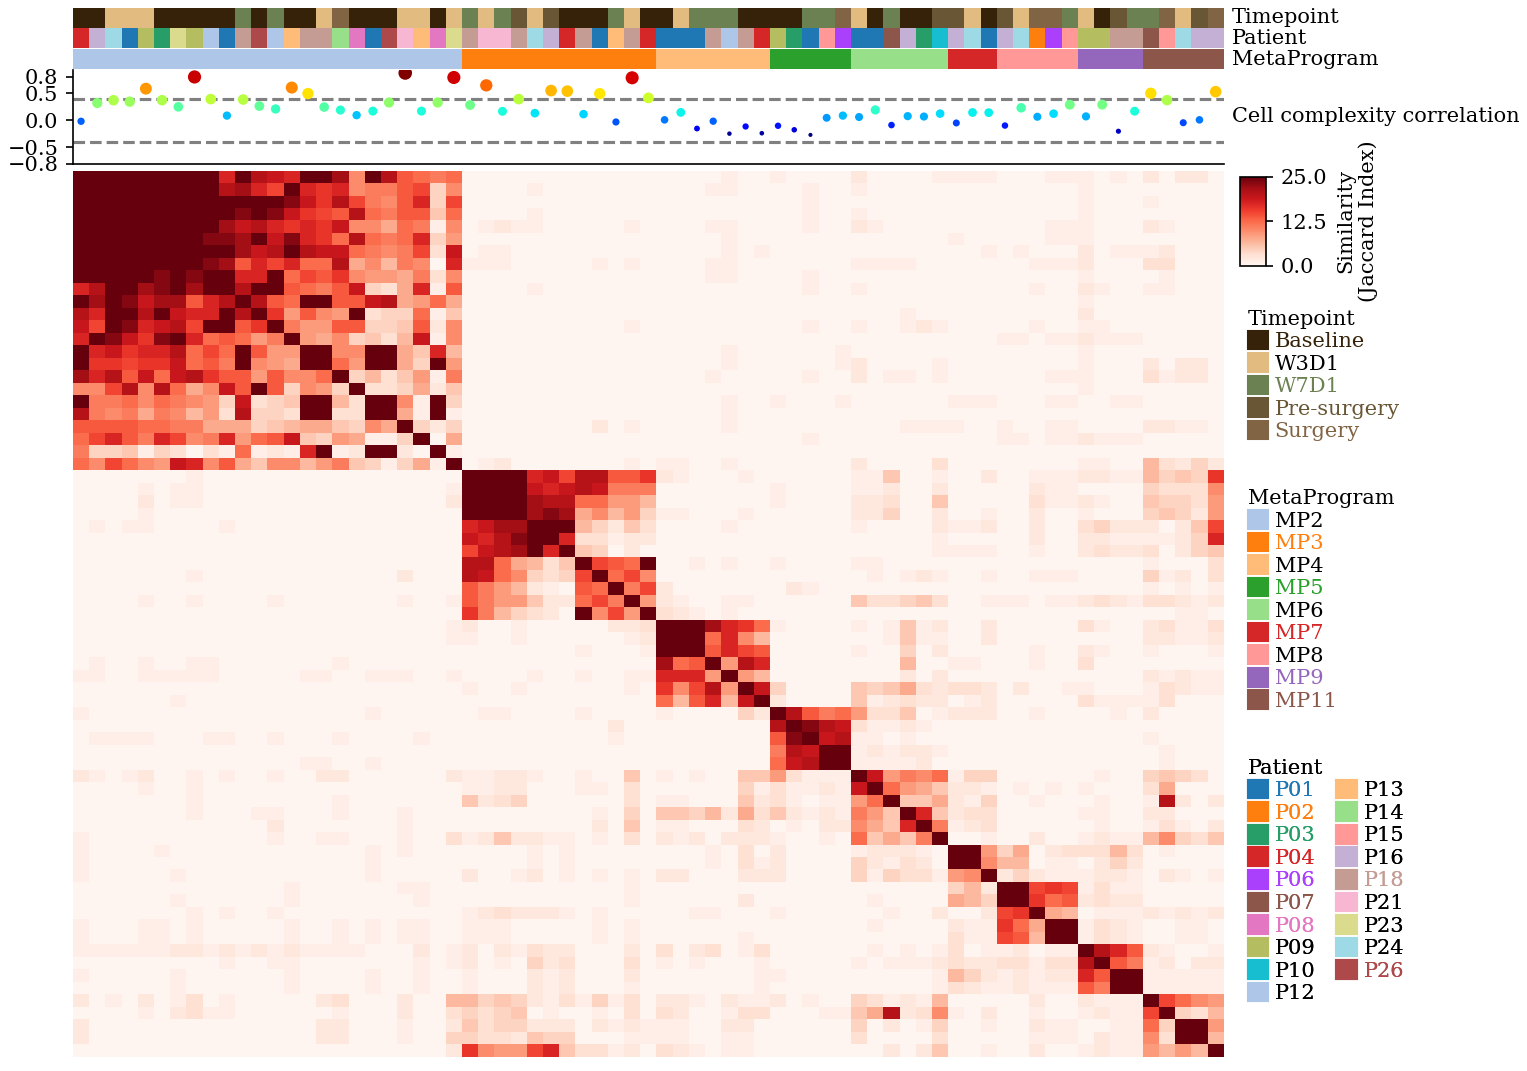

In [17]:
from PyComplexHeatmap import \
ClusterMapPlotter,HeatmapAnnotation,anno_simple,anno_label,DotClustermapPlotter,anno_scatterplot
## Get the order the program
anno['Cell_complexity_cor'] = nmf_corr_complexity
order = New_Programs_Order

## column annotation
n_mp = Cluster_Map.nunique()
COLOR_PAlETTE['MetaProgram'] = MP_colors
col_dict={}
for col in ['Timepoint','Patient','MetaProgram']:#'Treatment_Arm','BestResponse',
    colors = { k:v for k,v in COLOR_PAlETTE[col].items() if k in anno[col].unique()}
    col_dict[col] = anno_simple(anno[col],
                              legend_kws=dict(frameon=False),
                              colors=colors)
    
col_dict['Cell complexity correlation']= anno_scatterplot(
    anno['Cell_complexity_cor'],height=14,legend=False,grid=False
)

col_ha = HeatmapAnnotation(**col_dict,verbose=0,axis=1)
row_ha = HeatmapAnnotation(
    MetaProgram = anno_simple(anno['MetaProgram'],legend=False),verbose=0,axis=0
)
## plot
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 8),dpi=150)


cm = ClusterMapPlotter(data=sm.loc[order,order],
                       top_annotation=col_ha,
                       row_cluster=False,col_cluster=False,
#                        left_annotation=row_ha,
#                        col_split=rph_anno['RPH'],row_split=rph_anno['RPH'],
#                        row_split_gap=0.8,col_split_gap=0.8,
                       vmin=0,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='Reds',rasterized=True)

## Change the ylim for the correlation plot
cutoff=.4
ax=col_ha.annotations[3].ax
ax.set_yticks([-0.8,-0.5,0,0.5,0.8]);
ax.axhline(y=cutoff,ls='--',color='gray')
ax.axhline(y=-cutoff,ls='--',color='gray')

## Write out the Genesets for every MP

In [18]:
mp_gmt_path = f'{RESULT_TABLE}/MPs/Tumor/MP_Programs.gmt'
with open(mp_gmt_path,'w') as f:
    for mp in New_MP_Genesets:
        f.write('\t'.join([mp,'MetaProgram_HRpos']+MP_Genesets[mp].tolist())+'\n')

with open(mp_gmt_path.replace('MP_Programs.gmt','MP_order_color.pickle'), 'wb') as handle:
    pickle.dump({
        'order':order,
        'col_ha':col_ha,
        'bg_genes':bg_genes,
        'MP_Colors':COLOR_PAlETTE['MetaProgram']
    }, handle, protocol=pickle.HIGHEST_PROTOCOL)



mp_anno_path = f'{RESULT_TABLE}/MPs/Tumor/MetaProgram_Annotation.csv'
anno.to_csv(mp_anno_path,index=True)
